In [1]:
# Expect this program to run for 30 minutes or more
# Load package
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output

n = norm.pdf
N = norm.cdf

In [2]:
# Load option data 
option_dataset = pd.read_csv('Option_Data.csv')
option_dataset.head()

,Spot price,Strike Price,Risk Free Rate,Volatility,Maturity,Dividend,Option Price,Noise,Option Price with Noise
0,55.84,72.592,0.013,0.276,1.78,0,3.569203,-0.262465,3.306738
1,57.96,34.776,0.033,0.171,0.85,0,24.146475,0.051402,24.197877
2,43.70,52.440,0.041,0.262,1.19,0,2.764509,0.172955,2.937464
3,54.44,65.328,0.041,0.289,1.63,0,5.529263,-0.037865,5.491398
4,53.42,58.762,0.037,0.322,1.20,0,6.357704,0.147198,6.504902


## Divide data into Training, Validation and Test set

In [3]:
# Include option price with and without noise in data set splitting for later BS mean error calculation on test set
y = option_dataset[['Option Price with Noise','Option Price']]
X = option_dataset[['Spot price', 'Strike Price', 'Risk Free Rate','Volatility','Maturity','Dividend']]

# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

## Feature Scaling

In [4]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## Define Neural Network

In [5]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation function and other related parameters 
# For more information regrading to activation functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (6,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mae",optimizer = "Adam")

In [7]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("bs_pricing_model_vFinal.h5",save_best_only = True)

# Early stopping allows you to stop your training early if no improvment is shown after cerain period
# Currently it is set at if no improvement occured in 5000 epochs, at the stop the model will also revert back to the best weight
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5000,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also help restoring to the best weight
# We put both here just to illustrate different ways to keep the best model

In [8]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, number of epochs, validation data, 
# and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training once our early stopping criterion is triggered
# Also, select the first column of y_train data array, which is the option price with noise column
history=model.fit(X_scaled_train,y_train[:,0],epochs= 50000,verbose = 0, validation_data=(X_scaled_vals,y_val[:,0]),
                 callbacks=[checkpoint_cb,early_stopping_cb])




## Calculate prediction error for both NN and BS analytical formula

In [9]:
# Load the best model you saved and calcuate MAE for testing set

model = keras.models.load_model("bs_pricing_model_vFinal.h5")

mae_test = model.evaluate(X_scaled_test,y_test[:,0],verbose=0)

print('Nerual network mean absoluste error on test set:', mae_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Nerual network mean absoluste error on test set: 0.12225558376312255


In [10]:
model_prediction = model.predict(X_scaled_test)
mean_error = np.average(model_prediction.T - y_test[:,0])
std_error = np.std(model_prediction.T - y_test[:,0])

mean_error_vs_BS_price = np.average(model_prediction.T - y_test[:,1])
std_error_vs_BS_price = np.std(model_prediction.T - y_test[:,1])

BS_mean_error = np.average(y_test[:,0] - y_test[:,1])
BS_std_error = np.std(y_test[:,0] - y_test[:,1])

print('Black-Scholes Statistics:')
print('Mean error on test set:',BS_mean_error)
print('Standard deviation of error on test set:',BS_std_error)
print(" ")
print('Neural Network Statistics:')
print('Mean error on test set vs. option price with noise:',mean_error)
print('Standard deviation of error on test set vs. option price with noise:',std_error)
print('Mean error on test set vs. BS analytical formula price:',mean_error_vs_BS_price)
print('Standard deviation of error on test set vs. BS analytical formula price:',std_error_vs_BS_price)



Black-Scholes Statistics:
Mean error on test set: 0.005381285272161471
Standard deviation of error on test set: 0.14823355567443217
 
Neural Network Statistics:
Mean error on test set vs. option price with noise: -0.002375611465584136
Standard deviation of error on test set vs. option price with noise: 0.1546465204415661
Mean error on test set vs. BS analytical formula price: 0.0030056738065773335
Standard deviation of error on test set vs. BS analytical formula price: 0.048179439291695665


## Review your results and export training history

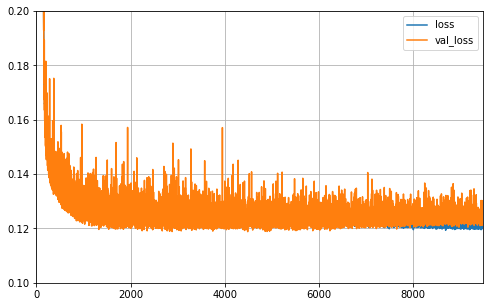

In [11]:
# Plot training history

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.1,0.2)
plt.show()

#Export your training history for MSE
output = pd.DataFrame(history.history)
output.to_csv("mae_history.csv")